In [1]:
import numpy as np
from torch.utils.data import DataLoader
import torch
from matplotlib import pyplot as plt

### Load dataset

In [2]:
from utils.data_utils import load_config
config = load_config("models/configurations/config.yaml")
config["dataset"]["len_seq_in"] = 1
config["dataset"]["len_seq_predict"] = 1

In [3]:
from utils.w4c_dataloader import RainData

valid_set = RainData("validation", **config["dataset"])

# this shifts the output timestamps so they match the input
for sample in valid_set.idxs:
    sample[1][0] -= 1

|YEARS] ['2019', '2020']


### Load model

In [4]:
from models.models import *

model = UNetCropUpscale(config)
model.unet.load_state_dict(torch.load("weights/sat2rad-unet.pt"))

<All keys matched successfully>

### Predict

In [6]:
predict_loader = iter(DataLoader(valid_set, batch_size=32, num_workers=0, shuffle=True))
with torch.no_grad():
    inp, out, _ = next(predict_loader)
    inp_cropped = inp[crop_slice()]
    pred = model(inp, False, False).detach()
    pred_cropped = model(inp, True, True).detach()
inp.shape, inp_cropped.shape, pred_cropped.shape, pred.shape

(torch.Size([32, 11, 1, 252, 252]),
 torch.Size([32, 11, 1, 42, 42]),
 torch.Size([32, 1, 1, 252, 252]),
 torch.Size([32, 1, 1, 252, 252]))

### Visualize

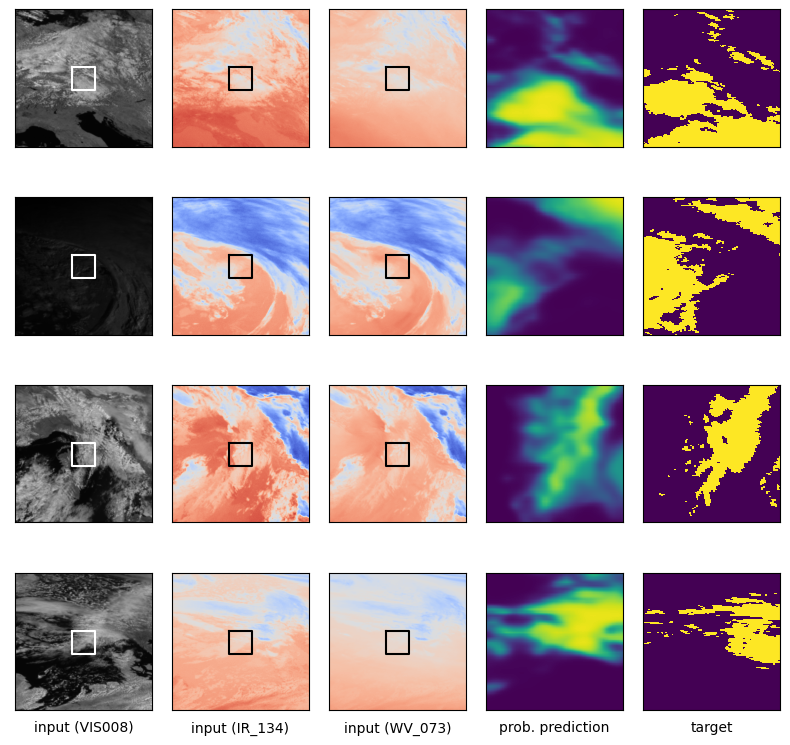

In [11]:
mean_rain_threshold = 0.15
indices = np.arange(len(inp))[out.mean(axis=(1, 2, 3, 4)) > mean_rain_threshold]  # select only interesting samples (with enough rain)
rect_x, rect_y = [105, 147, 147, 105, 105], [105, 105, 147, 147, 105]  # crop vis. rectangle coords

fig, axs = plt.subplots(len(indices), 5, figsize=(8, len(indices) * 2))
for axi, i in enumerate(indices):
    axs[axi, 0].imshow(inp[i, 8, 0], cmap="gray", vmin=inp[:, 8].min(), vmax=inp[:, 8].max())
    axs[axi, 0].plot(rect_x, rect_y, color="white")
    axs[axi, 1].imshow(inp[i, 6, 0], cmap="coolwarm", vmin=inp[:, 6].min(), vmax=inp[:, 6].max())
    axs[axi, 1].plot(rect_x, rect_y, color="black")
    axs[axi, 2].imshow(inp[i, 10, 0], cmap="coolwarm", vmin=inp[:, 10].min(), vmax=inp[:, 10].max())
    axs[axi, 2].plot(rect_x, rect_y, color="black")
    axs[axi, 3].imshow(torch.sigmoid(pred_cropped[i, 0, 0]), vmin=0, vmax=1, interpolation="none")
    axs[axi, 4].imshow(out[i, 0, 0], interpolation="none", vmin=0, vmax=1)

for ax in axs.ravel(): ax.set_xticks([])
for ax in axs.ravel(): ax.set_yticks([])

plt.setp(axs[-1, 0], xlabel='input (VIS008)')
plt.setp(axs[-1, 1], xlabel='input (IR_134)')
plt.setp(axs[-1, 2], xlabel='input (WV_073)')
plt.setp(axs[-1, 3], xlabel='prob. prediction')
plt.setp(axs[-1, 4], xlabel='target')

plt.tight_layout()
plt.show()